In [374]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error

In [140]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [141]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [142]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

# convert trajectory indices into row indices
row_indices = [i * 257 for i in traj_zero]

print("Trajectories starting with zeros:", traj_zero)
print("Corresponding starting rows:", row_indices)

Trajectories starting with zeros: [1050, 4058]
Corresponding starting rows: [269850, 1042906]


In [143]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [144]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [145]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [146]:
train_cleaned = remove_collision(train_cleaned)

CHECK ANOMALIES ON THE DATABASE TRAIN_CLEANED

In [148]:
def check_dataset_anomalies(df):
    print("Dataset anomalies check\n")

    # 1. Check for missing values (NaN)
    missing = df.isnull().sum().sum()
    if missing == 0:
        print("No missing values (NaN) found.")
    else:
        print(f"Found {missing} missing values (NaN).")
        print(df.isnull().sum()[df.isnull().sum() > 0])

    # 2. Check for infinite values
    inf_mask = df.isin([np.inf, -np.inf])
    inf_count = inf_mask.sum().sum()
    if inf_count == 0:
        print("No infinite values (+inf, -inf) found.")
    else:
        print(f"Found {inf_count} infinite values.")
        print(inf_mask.sum()[inf_mask.sum() > 0])

    # 3. Check for empty columns
    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    if not empty_cols:
        print("No empty columns.")
    else:
        print(f"Found empty columns: {empty_cols}")


In [149]:
check_dataset_anomalies(train_cleaned)

Dataset anomalies check

No missing values (NaN) found.
No infinite values (+inf, -inf) found.
No empty columns.


CHECK THE STATISTICS OF THE DATASET

In [151]:
def dataset_summary(df):
    # Shape
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
    # Stats per column
    print("Basic statistics per column:")
    desc = df.describe().T
    print(desc[['min', 'mean', 'max']])

    # Standard deviation
    desc['std'] = df.std()
    print("\nStandard deviation:")
    print(desc['std'])

In [152]:
train_cleaned_no_id = train_cleaned.iloc[:, :-1]
dataset_summary(train_cleaned_no_id)

Shape: 1089790 rows, 13 columns

Basic statistics per column:
             min      mean        max
t       0.000000  4.887787  10.000000
x_1   -30.823004 -0.331674  16.340610
y_1   -17.857729 -0.129133  26.276226
v_x_1 -72.993333 -0.217109  23.503455
v_y_1 -23.109278 -0.019456  34.671679
x_2   -30.833398  0.008456  15.506957
y_2   -52.450808 -0.096702  35.679463
v_x_2 -25.895550  0.038295  72.718229
v_y_2 -48.289007 -0.098585  23.118346
x_3   -17.439994  0.323218  61.656402
y_3   -33.159997  0.225835  27.735539
v_x_3 -30.970540  0.178814  25.964992
v_y_3 -25.509384  0.118041  48.288738

Standard deviation:
t        2.918751
x_1      1.836845
y_1      1.266963
v_x_1    0.949104
v_y_1    0.875636
x_2      1.154264
y_2      1.127168
v_x_2    1.016519
v_y_2    1.058225
x_3      1.562294
y_3      1.825727
v_x_3    0.852717
v_y_3    0.944614
Name: std, dtype: float64


#task 1.1

In [154]:
def split_trajectories(df, 
                                train_size=0.6, 
                                validation_size=0.2, 
                                test_size=0.2, 
                                method="random", 
                                random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Identifier les indices de début de trajectoire
    traj_start_indices = df.index[df['t'] == 0].tolist()
    traj_start_indices.append(len(df))  # ajouter la fin pour le dernier bloc

    # Construire les slices de trajectoires
    traj_slices = [(traj_start_indices[i], traj_start_indices[i+1]) for i in range(len(traj_start_indices)-1)]
    
    if method == "random":
        np.random.shuffle(traj_slices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_traj = len(traj_slices)
    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si reste
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining

    train_slices = traj_slices[:n_train]
    val_slices = traj_slices[n_train:n_train+n_val]
    test_slices = traj_slices[n_train+n_val:n_train+n_val+n_test]

    # Concaténer les DataFrames correspondants
    train_df = pd.concat([df.iloc[start:end] for start, end in train_slices])
    val_df = pd.concat([df.iloc[start:end] for start, end in val_slices])
    test_df = pd.concat([df.iloc[start:end] for start, end in test_slices])

    return train_df, val_df, test_df


In [155]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [170]:
print(train_after_split.shape)
print(validation_after_split.shape)
print(test_after_split.shape)

(652116, 14)
(216868, 14)
(220806, 14)


In [172]:
# Récupérer les ensembles d'IDs pour chaque split
train_ids = set(train_after_split['Id'].unique())
val_ids = set(validation_after_split['Id'].unique())
test_ids = set(test_after_split['Id'].unique())

# Vérifier les intersections
print("Train ∩ Validation :", train_ids & val_ids)
print("Train ∩ Test :", train_ids & test_ids)
print("Validation ∩ Test :", val_ids & test_ids)

Train ∩ Validation : set()
Train ∩ Test : set()
Validation ∩ Test : set()


In [296]:
train_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
998479,0.000000,1.000000,0.000000e+00,0.000000,0.000000,-0.476872,0.403835,0.000000,0.000000,-0.523128,-0.403835,0.000000,0.000000,1175261
998480,0.039062,0.999389,7.091184e-06,-0.031298,0.000363,-0.476625,0.402584,0.012662,-0.064105,-0.522764,-0.402591,0.018636,0.063742,1175262
998481,0.078125,0.997553,2.832455e-05,-0.062704,0.000724,-0.475883,0.398817,0.025332,-0.128949,-0.521671,-0.398845,0.037372,0.128226,1175263
998482,0.117188,0.994487,6.357763e-05,-0.094328,0.001080,-0.474646,0.392490,0.038014,-0.195325,-0.519842,-0.392553,0.056314,0.194244,1175264
998483,0.156250,0.990180,1.126400e-04,-0.126285,0.001430,-0.472913,0.383525,0.050710,-0.264133,-0.517267,-0.383638,0.075575,0.262703,1175265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998734,9.960940,4.076422,3.130647e+00,2.137102,1.614102,-2.024468,-1.533890,-3.701086,-0.784179,-2.051954,-1.596756,1.563984,-0.829923,1175516
998735,10.000000,4.159883,3.193682e+00,2.136080,1.613317,-2.043165,-1.615573,0.423169,0.692401,-2.116717,-1.578109,-2.559249,-2.305719,1175517
670681,0.000000,1.000000,0.000000e+00,0.000000,0.000000,-0.496890,0.370656,0.000000,0.000000,-0.503110,-0.370656,0.000000,0.000000,787705
670682,0.039062,0.999379,8.981136e-07,-0.031788,0.000046,-0.496590,0.369189,0.015356,-0.075208,-0.502789,-0.369190,0.016432,0.075162,787706


In [298]:
validation_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
475039,0.000000,1.000000,0.000000,0.000000,0.000000,-0.431152,0.618110,0.000000,0.000000,-0.568848,-0.618110,0.000000,0.000000,553835
475040,0.039062,0.999462,0.000026,-0.027550,0.001337,-0.430919,0.617495,0.011965,-0.031483,-0.568543,-0.617521,0.015584,0.030146,553836
475041,0.078125,0.997847,0.000105,-0.055169,0.002677,-0.430217,0.615649,0.023956,-0.063074,-0.567629,-0.615753,0.031213,0.060397,553837
475042,0.117188,0.995150,0.000235,-0.082931,0.004019,-0.429047,0.612564,0.035998,-0.094882,-0.566103,-0.612800,0.046933,0.090863,553838
475043,0.156250,0.991365,0.000419,-0.110907,0.005368,-0.427404,0.608232,0.048117,-0.127022,-0.563961,-0.608650,0.062790,0.121654,553839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475294,9.960940,1.368295,1.495876,0.308658,0.468209,-0.503923,-0.831087,0.167679,-1.127294,-0.864372,-0.664789,-0.476337,0.659085,554090
475295,10.000000,1.380243,1.514045,0.303074,0.462053,-0.501304,-0.873020,-0.024385,-1.019657,-0.878939,-0.641025,-0.278689,0.557604,554091
413097,0.000000,1.000000,0.000000,0.000000,0.000000,-0.116161,0.934891,0.000000,0.000000,-0.883839,-0.934891,0.000000,0.000000,482903
413098,0.039062,0.999570,0.000154,-0.022045,0.007910,-0.115956,0.934487,0.010499,-0.020683,-0.883613,-0.934642,0.011545,0.012774,482904


In [300]:
test_after_split.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
399878,0.000000,1.000000,0.000000,0.000000,0.000000,-0.492094,0.487517,0.000000,0.000000,-0.507906,-0.487517,0.000000,0.000000,467226
399879,0.039062,0.999416,0.000003,-0.029884,0.000139,-0.491813,0.486618,0.014410,-0.046047,-0.507604,-0.486621,0.015474,0.045908,467227
399880,0.078125,0.997664,0.000011,-0.059859,0.000277,-0.490968,0.483915,0.028860,-0.092402,-0.506696,-0.483926,0.030999,0.092124,467228
399881,0.117188,0.994738,0.000024,-0.090020,0.000416,-0.489557,0.479391,0.043392,-0.139384,-0.505180,-0.479415,0.046627,0.138968,467229
399882,0.156250,0.990628,0.000043,-0.120461,0.000553,-0.487576,0.473013,0.058048,-0.187340,-0.503051,-0.473057,0.062413,0.186786,467230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775822,8.398440,-0.152715,0.621635,0.526873,0.689759,0.033120,0.235274,-0.844557,-0.513696,0.119594,-0.856909,0.317685,-0.176063,913079
775823,8.437500,-0.130515,0.644529,0.603877,0.482976,-0.001370,0.218294,-0.915277,-0.356205,0.131885,-0.862823,0.311400,-0.126771,913080
775824,8.476560,-0.105954,0.659418,0.648716,0.280036,-0.037952,0.207400,-0.952605,-0.202123,0.143907,-0.866819,0.303889,-0.077913,913081
775825,8.515620,-0.080193,0.666456,0.665902,0.080880,-0.075417,0.202463,-0.961060,-0.051160,0.155611,-0.868918,0.295158,-0.029720,913082


#task 1.2

In [302]:
def replicate_initial_position_by_block(df):
    print("ici")
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]
    
    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values
    
    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc
    
    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée
        
    
    copy[coords] = data
    return copy


In [306]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

ici
ici
ici


In [308]:
train_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
998479,0.000000,1.0,0.0,0.000000,0.000000,-0.476872,0.403835,0.000000,0.000000,-0.523128,-0.403835,0.000000,0.000000,1175261
998480,0.039062,1.0,0.0,-0.031298,0.000363,-0.476872,0.403835,0.012662,-0.064105,-0.523128,-0.403835,0.018636,0.063742,1175262
998481,0.078125,1.0,0.0,-0.062704,0.000724,-0.476872,0.403835,0.025332,-0.128949,-0.523128,-0.403835,0.037372,0.128226,1175263
998482,0.117188,1.0,0.0,-0.094328,0.001080,-0.476872,0.403835,0.038014,-0.195325,-0.523128,-0.403835,0.056314,0.194244,1175264
998483,0.156250,1.0,0.0,-0.126285,0.001430,-0.476872,0.403835,0.050710,-0.264133,-0.523128,-0.403835,0.075575,0.262703,1175265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998734,9.960940,1.0,0.0,2.137102,1.614102,-0.476872,0.403835,-3.701086,-0.784179,-0.523128,-0.403835,1.563984,-0.829923,1175516
998735,10.000000,1.0,0.0,2.136080,1.613317,-0.476872,0.403835,0.423169,0.692401,-0.523128,-0.403835,-2.559249,-2.305719,1175517
670681,0.000000,1.0,0.0,0.000000,0.000000,-0.496890,0.370656,0.000000,0.000000,-0.503110,-0.370656,0.000000,0.000000,787705
670682,0.039062,1.0,0.0,-0.031788,0.000046,-0.496890,0.370656,0.015356,-0.075208,-0.503110,-0.370656,0.016432,0.075162,787706


In [310]:
validation_entry.head(260)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
475039,0.000000,1.0,0.0,0.000000,0.000000,-0.431152,0.618110,0.000000,0.000000,-0.568848,-0.618110,0.000000,0.000000,553835
475040,0.039062,1.0,0.0,-0.027550,0.001337,-0.431152,0.618110,0.011965,-0.031483,-0.568848,-0.618110,0.015584,0.030146,553836
475041,0.078125,1.0,0.0,-0.055169,0.002677,-0.431152,0.618110,0.023956,-0.063074,-0.568848,-0.618110,0.031213,0.060397,553837
475042,0.117188,1.0,0.0,-0.082931,0.004019,-0.431152,0.618110,0.035998,-0.094882,-0.568848,-0.618110,0.046933,0.090863,553838
475043,0.156250,1.0,0.0,-0.110907,0.005368,-0.431152,0.618110,0.048117,-0.127022,-0.568848,-0.618110,0.062790,0.121654,553839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475294,9.960940,1.0,0.0,0.308658,0.468209,-0.431152,0.618110,0.167679,-1.127294,-0.568848,-0.618110,-0.476337,0.659085,554090
475295,10.000000,1.0,0.0,0.303074,0.462053,-0.431152,0.618110,-0.024385,-1.019657,-0.568848,-0.618110,-0.278689,0.557604,554091
413097,0.000000,1.0,0.0,0.000000,0.000000,-0.116161,0.934891,0.000000,0.000000,-0.883839,-0.934891,0.000000,0.000000,482903
413098,0.039062,1.0,0.0,-0.022045,0.007910,-0.116161,0.934891,0.010499,-0.020683,-0.883839,-0.934891,0.011545,0.012774,482904


In [322]:
test_entry.head(50)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
399878,0.000000,1.0,0.0,0.000000,0.000000,-0.492094,0.487517,0.000000,0.000000,-0.507906,-0.487517,0.000000,0.000000,467226
399879,0.039062,1.0,0.0,-0.029884,0.000139,-0.492094,0.487517,0.014410,-0.046047,-0.507906,-0.487517,0.015474,0.045908,467227
399880,0.078125,1.0,0.0,-0.059859,0.000277,-0.492094,0.487517,0.028860,-0.092402,-0.507906,-0.487517,0.030999,0.092124,467228
399881,0.117188,1.0,0.0,-0.090020,0.000416,-0.492094,0.487517,0.043392,-0.139384,-0.507906,-0.487517,0.046627,0.138968,467229
399882,0.156250,1.0,0.0,-0.120461,0.000553,-0.492094,0.487517,0.058048,-0.187340,-0.507906,-0.487517,0.062413,0.186786,467230
399883,0.195312,1.0,0.0,-0.151284,0.000690,-0.492094,0.487517,0.072871,-0.236657,-0.507906,-0.487517,0.078413,0.235966,467231
399884,0.234375,1.0,0.0,-0.182596,0.000826,-0.492094,0.487517,0.087906,-0.287784,-0.507906,-0.487517,0.094690,0.286958,467232
399885,0.273438,1.0,0.0,-0.214514,0.000960,-0.492094,0.487517,0.103202,-0.341263,-0.507906,-0.487517,0.111311,0.340304,467233
399886,0.312500,1.0,0.0,-0.247165,0.001091,-0.492094,0.487517,0.118811,-0.397767,-0.507906,-0.487517,0.128354,0.396675,467234
399887,0.351562,1.0,0.0,-0.280692,0.001220,-0.492094,0.487517,0.134785,-0.458159,-0.507906,-0.487517,0.145907,0.456939,467235


In [342]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),       
    ('regressor', LinearRegression())   
])

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline.fit(X_train, y_train)

coefficients = pipeline.named_steps['regressor'].coef_  # shape = (n_targets, n_features)
intercepts = pipeline.named_steps['regressor'].intercept_  # shape = (n_targets,)

# Afficher les coefficients pour chaque target
for i, target in enumerate(target_cols):
    print(f"\nCoefficients pour {target} :")
    for col, coef in zip(input_cols, coefficients[i]):
        print(f"  {col}: {coef}")
    print(f"Intercept: {intercepts[i]}")



Coefficients pour x_1 :
  t: -0.5501757880593378
  x_1: -1314502770.078999
  y_1: 98243617.41518779
  x_2: -73285465222.94484
  y_2: 1022180951091.7052
  x_3: -73285465223.43817
  y_3: 1022180951091.991
Intercept: -0.32695998751756034

Coefficients pour y_1 :
  t: -0.05717207388649141
  x_1: -66220164.79441746
  y_1: 4949184.09965699
  x_2: 213152591888.53857
  y_2: 51467271877.43545
  x_3: 213152591888.49463
  y_3: 51467271877.6759
Intercept: -0.14313174314446125

Coefficients pour x_2 :
  t: 0.06160443450707386
  x_1: 574650281.5865259
  y_1: -42948347.67008506
  x_2: 44162821654.75465
  y_2: -446859868627.153
  x_3: 44162821654.842804
  y_3: -446859868627.09576
Intercept: -0.010472388459324305

Coefficients pour y_2 :
  t: -0.25017003558618417
  x_1: -164335267.42884928
  y_1: 12282127.007115295
  x_2: -42163245070.69353
  y_2: 127794120020.76395
  x_3: -42163245070.79178
  y_3: 127794120020.83377
Intercept: -0.10054100214129758

Coefficients pour x_3 :
  t: 0.4885713535558457
  x_

In [376]:
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline.predict(X_val) 


rmse_value = root_mean_squared_error(y_val, y_pred_val)#fonction de la librairie
print("RMSE global :", rmse_value)

RMSE global : 1.4571219793246797


In [378]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.show()

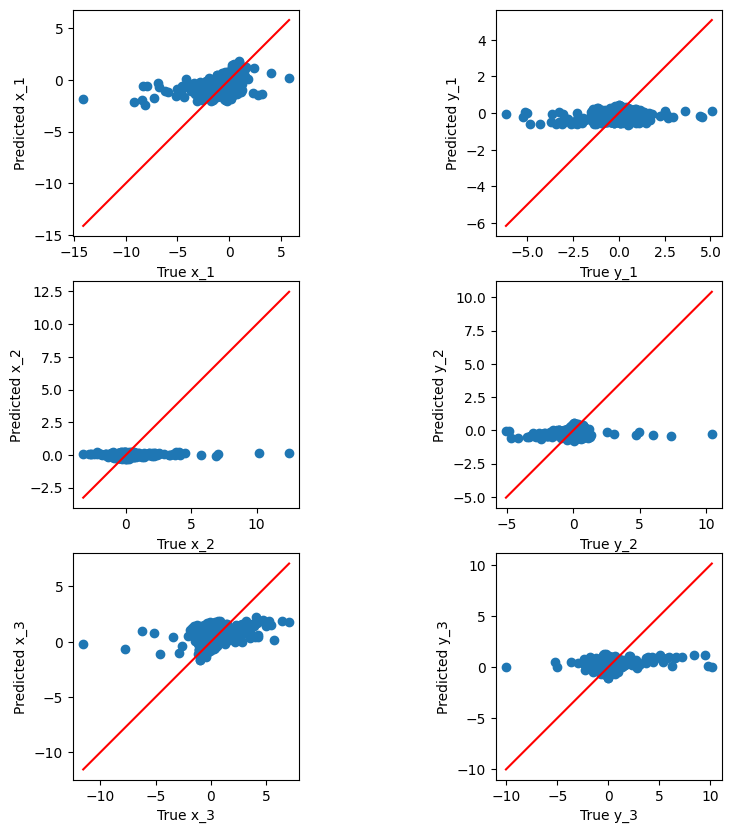

In [382]:
#Prends des points randoms si >500 points
plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")